# Определение перспективного тарифа для телеком компании

В yашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализируем поведение клиентов и сделаем вывод — какой тариф приносит больше денег.

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
calls = pd.read_csv('datasets/calls.csv')
internet = pd.read_csv('datasets/internet.csv')
messages = pd.read_csv('datasets/messages.csv')
tariffs = pd.read_csv('datasets/tariffs.csv')
users = pd.read_csv('datasets/users.csv')

### Шаг 2. Подготовьте данные

In [3]:
del internet['Unnamed: 0'] #удалим столбец, дублирующий индексы
del internet['id'] #удалим индексы действий
del messages['id']
del calls['id']
#слегка переименуем столбцы, чтобы их названия занимали меньше места
users.columns = ['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff_name']
tariffs.columns = ['mes_incl', 'mb_incl', 'min_incl', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_mes', 'rub_per_min', 'tariff_name']

In [4]:
#переведем даты в правильный формат
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y.%m.%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y.%m.%d')

In [5]:
# оставим только звонки с продолжительностью больше 0 секунд и округлим длительность звонков в большую сторону
calls_clear = calls.loc[calls['duration'] > 0]
calls_clear = calls_clear.copy()
calls_clear['duration'] = calls_clear['duration'].apply(np.ceil)

# округлим количество мегабайт в большую сторону
internet = internet.copy()
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

In [6]:
#добавим столбец с месяцем, в который совершались расходные действия
calls_clear['month_year'] = calls_clear['call_date'].dt.to_period('M')
internet['month_year'] = internet['session_date'].dt.to_period('M')
messages['month_year'] = messages['message_date'].dt.to_period('M')

In [7]:
#сгруппируем звонки по пользователям и подсчитаем количество звонков и их продолжительность для каждого клиента в месяц
calls_grouped = calls_clear.pivot_table(index=('user_id', 'month_year'), values='duration', aggfunc=('count', 'sum'))
calls_grouped.columns = ['calls_count', 'min_sum']
calls_grouped.head()

# так как в данной работе мы не пользуемся показателем минимума, условимся, что под 'min' мы будем понимать минуты

calls_count  min_sum
user_id month_year                      
1000    2018-05              17    159.0
        2018-06              28    172.0
        2018-07              41    340.0
        2018-08              42    408.0
        2018-09              46    466.0

In [8]:
#сгруппируем выходы в интернет по пользователям и подсчитаем объем трафика для каждого клиента в месяц
internet_grouped = internet.pivot_table(index=('user_id', 'month_year'), values='mb_used', aggfunc='sum')
internet_grouped.columns = ['mb_sum']
internet_grouped.head()

mb_sum
user_id month_year         
1000    2018-05      2256.0
        2018-06     23257.0
        2018-07     14016.0
        2018-08     14070.0
        2018-09     14581.0

In [9]:
#сгруппируем СМС по пользователям и подсчитаем количество СМС для каждого клиента в месяц
messages_grouped = messages.pivot_table(index=('user_id', 'month_year'), values='message_date', aggfunc='count')
messages_grouped.columns = ['mes_count']
messages_grouped.head()

mes_count
user_id month_year           
1000    2018-05            22
        2018-06            60
        2018-07            75
        2018-08            81
        2018-09            57

In [10]:
# объединим все расходные действия пользователей по месяцам в одну сводную таблицу
actions_merged = pd.merge(internet_grouped, messages_grouped, on=('user_id', 'month_year'), how='outer')
actions_merged = pd.merge(actions_merged, calls_grouped, on=('user_id', 'month_year'), how='outer')
actions_merged.head()

mb_sum  mes_count  calls_count  min_sum
user_id month_year                                          
1000    2018-05      2256.0       22.0         17.0    159.0
        2018-06     23257.0       60.0         28.0    172.0
        2018-07     14016.0       75.0         41.0    340.0
        2018-08     14070.0       81.0         42.0    408.0
        2018-09     14581.0       57.0         46.0    466.0

In [11]:
# объединим все расходные действия пользователей по месяцам с информацией о пользователях
users_and_actions = pd.merge(users, actions_merged, on='user_id', how='outer')
users_and_actions.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,mb_sum,mes_count,calls_count,min_sum
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2256.0,22.0,17.0,159.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,23257.0,60.0,28.0,172.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14016.0,75.0,41.0,340.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14070.0,81.0,42.0,408.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14581.0,57.0,46.0,466.0


In [12]:
# объединим  информацию о пользователях, их тарифах и расходных действиях по месяцам в одну супер-таблицу
users_actions_tariffs = pd.merge(users_and_actions, tariffs, on='tariff_name', how='outer')
users_actions_tariffs.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,mb_sum,mes_count,calls_count,min_sum,mes_incl,mb_incl,min_incl,rub_monthly_fee,rub_per_gb,rub_per_mes,rub_per_min
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2256.0,22.0,17.0,159.0,1000,30720,3000,1950,150,1,1
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,23257.0,60.0,28.0,172.0,1000,30720,3000,1950,150,1,1
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14016.0,75.0,41.0,340.0,1000,30720,3000,1950,150,1,1
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14070.0,81.0,42.0,408.0,1000,30720,3000,1950,150,1,1
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14581.0,57.0,46.0,466.0,1000,30720,3000,1950,150,1,1


In [13]:
# слегка поменяем порядок столбцов для наглядности
users_actions_tariffs = users_actions_tariffs[['user_id', 'age',
 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff_name', 'mb_sum', 'mb_incl', 'rub_per_gb', 'mes_count',
 'mes_incl', 'rub_per_mes', 'calls_count', 'min_sum', 'min_incl', 'rub_per_min', 'rub_monthly_fee']]
users_actions_tariffs.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,mb_sum,mb_incl,rub_per_gb,mes_count,mes_incl,rub_per_mes,calls_count,min_sum,min_incl,rub_per_min,rub_monthly_fee
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2256.0,30720,150,22.0,1000,1,17.0,159.0,3000,1,1950
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,23257.0,30720,150,60.0,1000,1,28.0,172.0,3000,1,1950
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14016.0,30720,150,75.0,1000,1,41.0,340.0,3000,1,1950
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14070.0,30720,150,81.0,1000,1,42.0,408.0,3000,1,1950
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14581.0,30720,150,57.0,1000,1,46.0,466.0,3000,1,1950


In [14]:
# подсчитаем количество потраченных мегабайт, минут и СМС сверх положенного по тарифу
users_actions_tariffs['extra_mb'] = users_actions_tariffs['mb_sum'] - users_actions_tariffs['mb_incl']
users_actions_tariffs['extra_min'] = users_actions_tariffs['min_sum'] - users_actions_tariffs['min_incl']
users_actions_tariffs['extra_mes'] = users_actions_tariffs['mes_count'] - users_actions_tariffs['mes_incl']
users_actions_tariffs.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,mb_sum,mb_incl,...,mes_incl,rub_per_mes,calls_count,min_sum,min_incl,rub_per_min,rub_monthly_fee,extra_mb,extra_min,extra_mes
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2256.0,30720,...,1000,1,17.0,159.0,3000,1,1950,-28464.0,-2841.0,-978.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,23257.0,30720,...,1000,1,28.0,172.0,3000,1,1950,-7463.0,-2828.0,-940.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14016.0,30720,...,1000,1,41.0,340.0,3000,1,1950,-16704.0,-2660.0,-925.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14070.0,30720,...,1000,1,42.0,408.0,3000,1,1950,-16650.0,-2592.0,-919.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14581.0,30720,...,1000,1,46.0,466.0,3000,1,1950,-16139.0,-2534.0,-943.0


In [15]:
# подсчитаем затраты на "излишние" мегабайты, смс и минуты согласно тарифному плану
users_actions_tariffs['mb_fee'] = users_actions_tariffs.loc[users_actions_tariffs['extra_mb'] > 0, 'extra_mb'] * users_actions_tariffs['rub_per_gb'] / 1024
users_actions_tariffs['min_fee'] = users_actions_tariffs.loc[users_actions_tariffs['extra_min'] > 0, 'extra_min'] * users_actions_tariffs['rub_per_min']
users_actions_tariffs['mes_fee'] = users_actions_tariffs.loc[users_actions_tariffs['extra_mes'] > 0, 'extra_mes'] * users_actions_tariffs['rub_per_mes']
# заменим NaN на нули
users_actions_tariffs = users_actions_tariffs.fillna(0)
# подсчитаем сумму затрат на излишки и добавим абонентскую плату
users_actions_tariffs['total_fee'] = users_actions_tariffs['mb_fee'] + users_actions_tariffs['min_fee'] + users_actions_tariffs['mes_fee'] + users_actions_tariffs['rub_monthly_fee']
users_actions_tariffs.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,mb_sum,mb_incl,...,min_incl,rub_per_min,rub_monthly_fee,extra_mb,extra_min,extra_mes,mb_fee,min_fee,mes_fee,total_fee
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2256.0,30720,...,3000,1,1950,-28464.0,-2841.0,-978.0,0.0,0.0,0.0,1950.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,23257.0,30720,...,3000,1,1950,-7463.0,-2828.0,-940.0,0.0,0.0,0.0,1950.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14016.0,30720,...,3000,1,1950,-16704.0,-2660.0,-925.0,0.0,0.0,0.0,1950.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14070.0,30720,...,3000,1,1950,-16650.0,-2592.0,-919.0,0.0,0.0,0.0,1950.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14581.0,30720,...,3000,1,1950,-16139.0,-2534.0,-943.0,0.0,0.0,0.0,1950.0


### Вывод по шагу 2.

Мы создали единую таблицу, в которой аккумулирована информация о клиентах, их тарифах, расходных действиях за месяц, а также подсчитаны их расходы.

### Шаг 3. Проанализируйте данные

In [16]:
# подсчитаем средние значения потраченных мегабайт, СМС и минут по тарифам, а также средние расходы по тарифам
all_data_grouped = users_actions_tariffs.pivot_table(index='tariff_name', values = ('mb_sum', 'min_sum', 'calls_count', 'mes_count', 'total_fee'), aggfunc='mean')
all_data_grouped

,calls_count,mb_sum,mes_count,min_sum,total_fee
tariff_name,,,,,
smart,46.926457,16221.910762,33.369058,417.747534,1233.043032
ultra,59.176471,19467.137931,49.313387,526.089249,2060.417872


#### Вывод

Пользователи тарифа "Смарт" в среднем в месяц делают 47 звонков, тратят около 16 Гб трафика, 33 сообщения и 418 минут звонков.

Пользователи тарифа "Ультра" в среднем в месяц делают 59 звонков, тратят около 19 Гб трафика, 49 сообщений и 526 минут звонков.

Cогласно нашей выборке, пользователи тарифа "Ультра" тратят в месяц в среднем заметно больше пользователей тарифа "Смарт" (2060 рублей против 1233). Случайны ли эти цифры - пока не знаем.

In [17]:
# подсчитаем средние значения потраченных мегабайт, СМС и минут, а также средние расходы для москвичей и жителей остальной России
region_data = users_actions_tariffs.copy()
region_data.loc[region_data['city'] != "Москва", 'city'] = 'неМосква'
region_data_grouped = region_data.pivot_table(index='city', values = ('mb_sum', 'min_sum', 'mes_count', 'total_fee'), aggfunc='mean')
region_data_grouped

,mb_sum,mes_count,min_sum,total_fee
city,,,,
Москва,17984.068740,37.877250,469.150573,1507.276762
неМосква,17036.926296,38.346641,446.698656,1481.885559


#### Вывод

Cогласно нашей выборке, москвичи тратят в месяц в слегка больше немосквичей (1507 рублей против 1481). Случайны ли эти цифры - пока не знаем.

In [18]:
# подсчитаем дисперсии и отклонения потраченных мегабайт, СМС и минут по тарифам, а также средние расходы по тарифу "Смарт"
for i in ('mb_sum', 'mes_count', 'min_sum'):
    print('Дисперсия', i, 'тарифа smart равна', np.var(users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='smart', i], ddof=1))
    print('Стандартное отклонение', i, 'тарифа smart равно', np.std(users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='smart', i], ddof=1))
    print()

Дисперсия mb_sum тарифа smart равна 34648523.30069166
Стандартное отклонение mb_sum тарифа smart равно 5886.299627158955

Дисперсия mes_count тарифа smart равна 796.9552557301129
Стандартное отклонение mes_count тарифа smart равно 28.230395954185852

Дисперсия min_sum тарифа smart равна 36281.39383644458
Стандартное отклонение min_sum тарифа smart равно 190.4767540579285



In [19]:
# подсчитаем дисперсии и отклонения потраченных мегабайт, СМС и минут по тарифам, а также средние расходы по тарифу "Ультра"
for i in ('mb_sum', 'mes_count', 'min_sum'):
    print('Дисперсия', i, 'тарифа ultra равна', np.var(users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='ultra', i], ddof=1))
    print('Стандартное отклонение', i, 'тарифа ultra равно', np.std(users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='ultra', i], ddof=1))
    print()

Дисперсия mb_sum тарифа ultra равна 102217264.27537195
Стандартное отклонение mb_sum тарифа ultra равно 10110.255401095066

Дисперсия mes_count тарифа ultra равна 2285.4174246558414
Стандартное отклонение mes_count тарифа ultra равно 47.80603962530092

Дисперсия min_sum тарифа ultra равна 101052.49354928387
Стандартное отклонение min_sum тарифа ultra равно 317.8875485911392



#### Вывод

Подобно средним значениям, дисперсии и отклонения средних потраченных мегабайт, смс и минут для пользователей тарифа "Ультра", больше, чем для пользователей тарифа "Смарт".

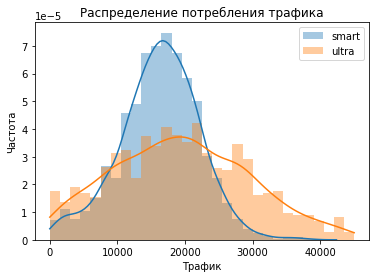

In [20]:
# построим гистограммы и график плотности распределения потраченных мегабайт для каждого тарифа
smart_mb = users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='smart', 'mb_sum']
ultra_mb = users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='ultra', 'mb_sum']
sns.distplot(smart_mb, bins=30, label='smart', hist_kws={'range': [0, 45000]}, kde_kws={'clip': [0, 45000]})
sns.distplot(ultra_mb, bins=30, label='ultra',  hist_kws={'range': [0, 45000]}, kde_kws={'clip': [0, 45000]})
plt.xlabel('Трафик')
plt.ylabel('Частота')
plt.title('Распределение потребления трафика')
plt.legend(loc='upper right')
plt.show()

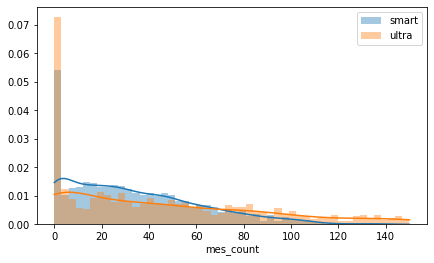

In [21]:
# построим гистограммы и график плотности распределения потраченных смс для каждого тарифа
smart_mes = users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='smart', 'mes_count']
ultra_mes = users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='ultra', 'mes_count']
plt.figure(figsize=(7,4))
sns.distplot(smart_mes, bins=50, label='smart', hist_kws={'range': [0, 150]}, kde_kws={'clip': [0, 150]})
sns.distplot(ultra_mes, bins=50, label='ultra', hist_kws={'range': [0, 150]}, kde_kws={'clip': [0, 150]})
plt.legend(loc='upper right')
plt.show()

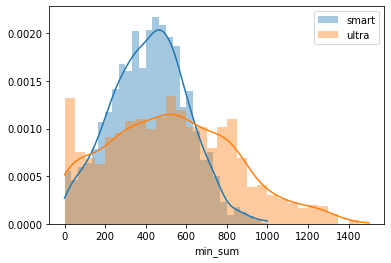

In [22]:
# построим гистограммы и график плотности распределения потраченных минут для каждого тарифа
smart_min = users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='smart', 'min_sum']
ultra_min = users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='ultra', 'min_sum']

sns.distplot(smart_min, bins=30, label='smart', hist_kws={'range': [0, 1000]}, kde_kws={'clip': [0, 1000]})
sns.distplot(ultra_min, bins=30, label='ultra', hist_kws={'range': [0, 1500]}, kde_kws={'clip': [0, 1500]})
plt.legend(loc='upper right')
plt.show()

#### Вывод

Гистограммы и графики распределения плотности потраченных минут, мегабайт и смс для пользователей тарифа "Ультра" сильнее скошены вправо, чем для пользователей тарифа "Смарт", что подтверждает табличные данные для средних значений. Иными словами, средний клиент на тарифе "Ультра" делает больше звонков, чаще выходит в интернет и отправляет сообщения, чем клиент на тарифе "Смарт".

Стоит заметить, что пики распределения минут, мегабайт и смс для тарифа "Смарт" близки к лимитам по тарифу, в то время как пики распределения для тарифа "Ультра" от лимита весьма далеки. 

Также примечательно, что с распространением мессенджеров большое количество пользователей обоих тарифов вообще не пользуется смс.

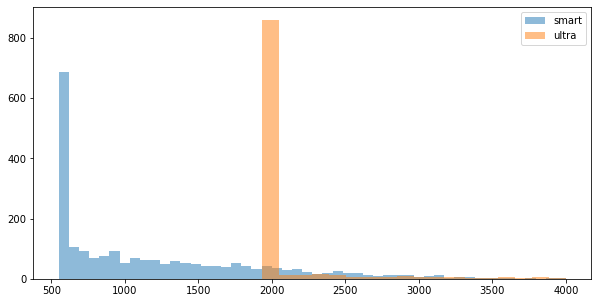

In [23]:
# построим гистограмму распределения потраченных денег для каждого тарифа
smart_fee = users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='smart', 'total_fee']
ultra_fee = users_actions_tariffs.loc[users_actions_tariffs['tariff_name']=='ultra', 'total_fee']

plt.figure(figsize=(10,5))
plt.hist(smart_fee, bins=50, alpha=0.5, label='smart', range=(550, 4000))
plt.hist(ultra_fee, bins=30, alpha=0.5, label='ultra', range=(550, 4000))
plt.legend(loc='upper right')
plt.show()

#### Вывод

Большинство пользователей обоих тарифов не тратит больше положенного по тарифу, в связи с чем платит только абонентскую плату (550 и 1950 рублей). Вместе с тем, пользователи тарифа "Смарт" чаще выходят за лимит (гистограмма относительно сильнее скошена вправо). 

Части пользователей тарифа "Смарт", чьи расходы, как видно на графике, превышают 1950 рублей, стоит предложить перейти на тариф "Ультра".

### Шаг 4. Проверьте гипотезы.

Проверим нулевую гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: средние расходы пользователей тарифа "Смарт" равны средним расходам пользователей тарифа "Ультра". Альтернативная гипотеза: эти показатели неравны.

In [24]:
alpha = 0.05 # задаём стандартный критический уровень статистической значимости

results = st.ttest_ind(smart_fee, ultra_fee) # проверяем гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue) # выводим на экран получившееся p-значение

if (results.pvalue < alpha): # сравниваем получившееся p-значение с заданным уровнем статистической значимости):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.129437607155033e-191
Отвергаем нулевую гипотезу


Проверим нулевую гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: средние расходы москвичей равны средним расходам немосквичей. Альтернативная гипотеза: эти показатели неравны.

In [25]:
moscow_fee = users_actions_tariffs.loc[users_actions_tariffs['city']=='Москва', 'total_fee']
non_moscow_fee = users_actions_tariffs.loc[users_actions_tariffs['city']!='Москва', 'total_fee']

alpha = 0.05 # задаём стандартный критический уровень статистической значимости

results = st.ttest_ind(moscow_fee, non_moscow_fee) # проверяем гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue) # выводим на экран получившееся p-значение

if (results.pvalue < alpha): # сравниваем получившееся p-значение с заданным уровнем статистической значимости):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4712668200760739
Не получилось отвергнуть нулевую гипотезу


### Вывод по шагу 4.

Как показала проверка, вероятность того, что средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова, крайне мала.
Таким образом, наш предварительный вывод на шаге 3 о том, что средние расходы пользователей тарифа "Ультра" превышают аналогичный показатель пользователей тарифа "Смарт" - не случаен.

В то же время, с вероятностью 47 % превышение расходов москвичей над расходами жителей остальной России является случайным.

### Шаг 5. Общий вывод.

В рамках проекта мы получили на вход набор данных о 500 клиентах оператора сотовой связи, их расходных действиях (звонки, интернет, смс) в течение 2018 года и об условиях тарифов "Смарт" и "Ультра".

В ходе работы была проведена преобработка данных:
- удалены данные о непринятых исходящих звонках (продолжительность 0.0 минут)
- показатели минут и мегабайт округлены согласно правилам оператора в большую сторону

Для удобства работы расходные действия каждого клиента были разбиты по месяцам и объединены в сводную таблицу. Используя информацию о том, каким тарифом пользуется клиент и каковы условия тарифа, мы посчитали сумму расходов каждого клиента в месяц.

Используя средние показатели, а также гистограммы и графики распределения плотности, мы обнаружили, что пользователи тарифа "Ультра" тратят больше мегабайт, минут и сообщений, чем пользователи тарифа "Смарт". В то же время последние чаще выходят за пределы установленных по тарифу лимитов. Были также зафиксированы показатели дисперсии и стандартного отклонения потраченных мегабайт, минут и сообщений для каждого тарифа.

Кроме того, мы выяснили, что:

- пользователи тарифа "Ультра" тратят в месяц в среднем заметно больше пользователей тарифа "Смарт" (2060 рублей против 1233)
- москвичи тратят в месяц в слегка больше немосквичей (1507 рублей против 1481)

Для проверки этих выводов мы сформулировали 2 нулевые гипотезы ('расходы пользователей тарифа "Смарт" равны расходам пользователей тарифа "Ультра"' и 'расходы москвичей равны расходам немосквичей'). Проверка позволила отвергнуть первую нулевую гипотезу, но не позволила отвергнуть вторую.

Таким образом, можно сделать общий вывод о том, что тариф "Ультра" действительно приносит оператору больше денег в расчёте на одного пользователя. В то же время достоверно сказать о том, что москвичи для оператора в среднем выгоднее жителей провинции, нельзя.
